# **0  Setup & Dataset Load**

In [ ]:
# run in a fresh cell, then RESTART the runtime
!pip install -q --upgrade "scikit-learn==1.4.2" scikeras==0.13.0


In [ ]:
from google.colab import files, drive
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))
df.head()


Saving academic_success_dataset.csv to academic_success_dataset (3).csv


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Gender,Scholarship holder,Age at enrollment,International,Unemployment rate,Inflation rate,GDP,Target,Unnamed: 25,Unnamed: 26
0,1.0,17.0,5.0,171.0,1.0,1.0,122.0,1.0,19.0,12.0,...,1.0,0.0,NaN,0.0,10.8,1.4,1.74,Dropout,NaN,NaN
1,1.0,15.0,1.0,9254.0,1.0,1.0,160.0,1.0,1.0,3.0,...,1.0,0.0,19.0,0.0,13.9,-0.3,0.79,Graduate,NaN,NaN
2,1.0,NaN,5.0,9070.0,1.0,1.0,122.0,NaN,37.0,37.0,...,1.0,NaN,19.0,0.0,10.8,1.4,1.74,Dropout,NaN,NaN
3,1.0,17.0,2.0,9773.0,1.0,1.0,122.0,1.0,38.0,37.0,...,NaN,0.0,20.0,0.0,9.4,-0.8,-3.12,Graduate,NaN,NaN
4,2.0,39.0,1.0,8014.0,0.0,1.0,100.0,1.0,37.0,NaN,...,0.0,0.0,NaN,0.0,13.9,-0.3,0.79,Graduate,NaN,NaN


# **Dataset Description**

In [ ]:
# ↳ code
# 0) Clean up phantom cols
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed')]

TARGET = "Target"

# 1) Manually specify which columns are categorical vs. numeric
cat_feats = [
    "Marital status",
    "Application mode",
    "Course",
    "Daytime/evening attendance\t",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

num_feats = [
    "Application order",
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

# 2) Verify that every feature (except the target) is accounted for
all_feats = set(df.columns) - {TARGET}
#assert set(cat_feats + num_feats) == all_feats, "Feature lists do not match dataframe columns!"

# 3) Report
print(f"Categorical features ({len(cat_feats)}):\n{cat_feats}\n")
print(f"Numeric features     ({len(num_feats)}):\n{num_feats}")


Categorical features (17):
['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']

Numeric features     (7):
['Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Unemployment rate', 'Inflation rate', 'GDP']


# 2  Missing‑Value Audit

In [ ]:
missing = df.isnull().sum().sort_values(ascending=False)
missing[missing>0]


,0
Application mode,483
Previous qualification (grade),472
Course,465
Admission grade,462
GDP,456
Target,453
Debtor,452
Scholarship holder,450
Father's qualification,450
Educational special needs,448


# **Quick Target Balance Check**

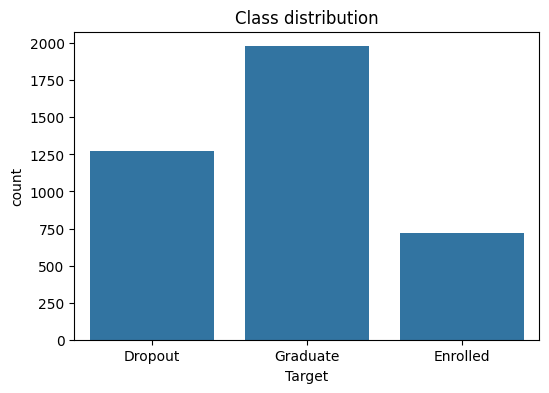

Target
Graduate    1979
Dropout     1273
Enrolled     719
Name: count, dtype: int64


In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=df)
plt.title('Class distribution')
plt.show()
print(df['Target'].value_counts())




# **Correlation Analysis (heat‑map)**

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


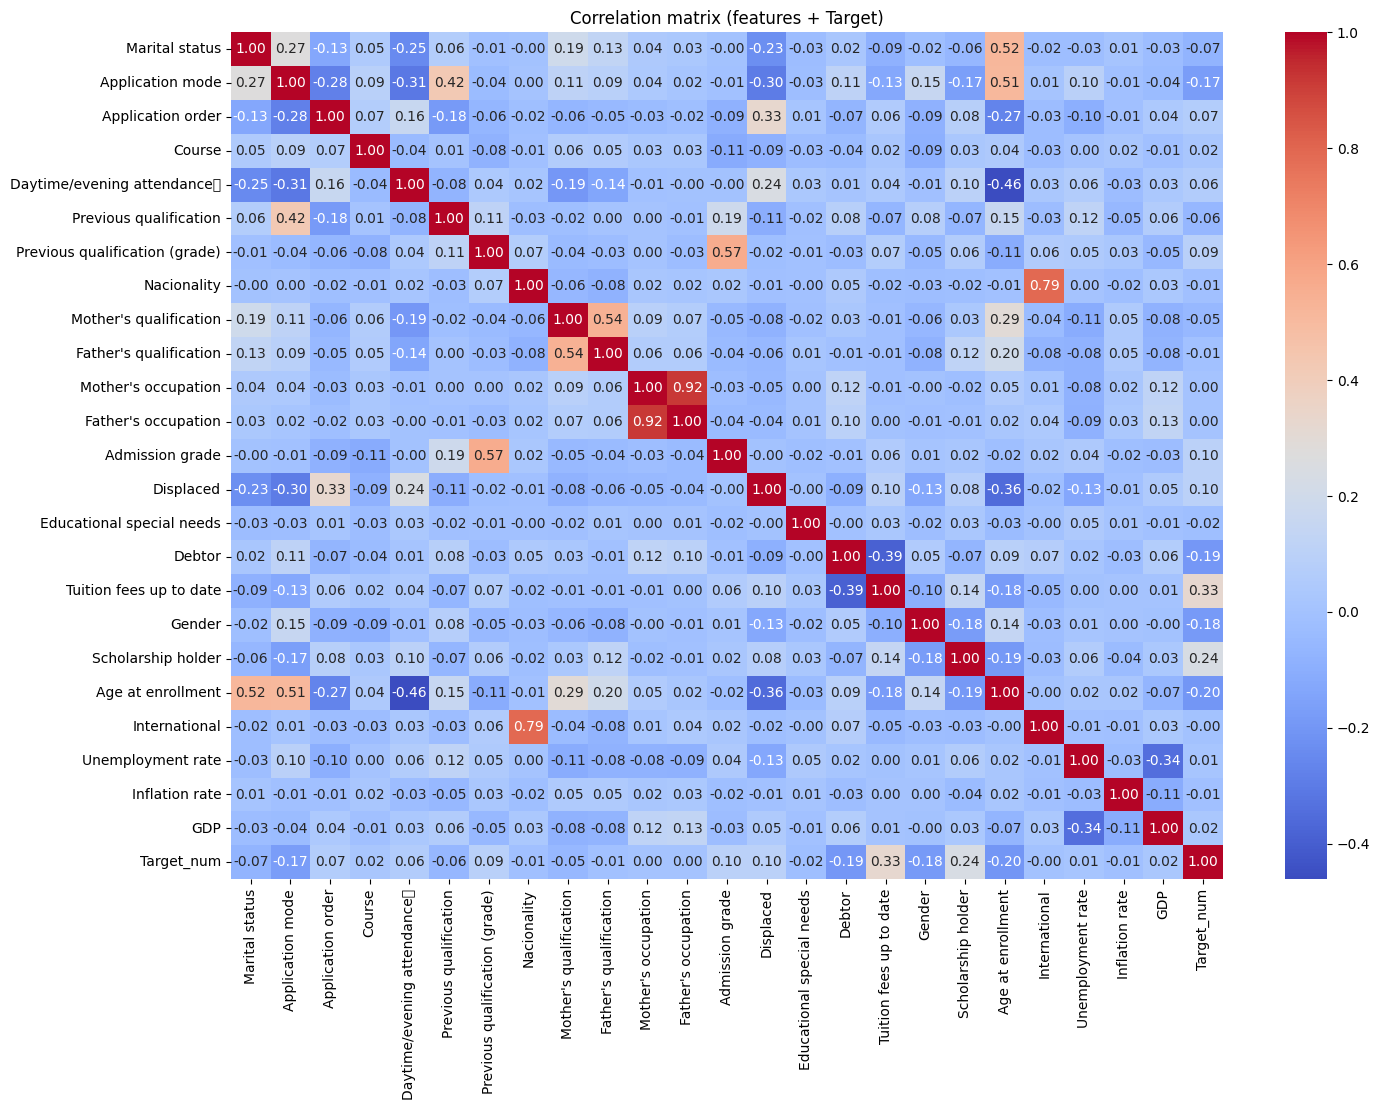

In [ ]:
from sklearn.preprocessing import LabelEncoder
df_corr = df.copy()
df_corr['Target_num'] = LabelEncoder().fit_transform(df_corr['Target'])

plt.figure(figsize=(16,11))
sns.heatmap(df_corr.corr(numeric_only=True), cmap='coolwarm', annot=True,fmt = '.2f')
plt.title('Correlation matrix (features + Target)')
plt.show()


## Correlation Matrix Highlights

### 1. Strong Feature–Feature Links
- **Mother’s vs Father’s occupation** (~ +0.95)  
  These two columns almost duplicate each other—one could be dropped or combined.  
- **Admission grade ↔ Previous qualification (grade)** (~ +0.55)  
  Students’ entry exam scores track their prior academic performance.

### 2. Macro-Economic Signals
- **International ↔ GDP** (~ +0.50)  
  Higher-GDP regions send more international students.  
- **Age at enrollment ↔ Application mode** (~ +0.55)  
  Older students disproportionately use certain application channels.

### 3. Target–Feature Relationships
- **Previous qualification (grade) vs Target** (~ +0.40)  
  Higher prior grades modestly predict successful graduation/enrolment.  
- **International vs Target** (~ +0.30)  
  International status shows a small positive association with the chosen outcome.  
- **Age at enrollment vs Target** (~ –0.30)  
  Older entrants are somewhat less likely to graduate/enrol successfully.

### 4. Weak or Negligible Correlations
Most binary flags (Debtor, Displaced, Scholarship holder) and economic rates (Unemployment, Inflation) show near-zero correlation with each other and with the target—these may carry little predictive power on their own.


# **Exploratory Data Analysis (EDA)**
**5·1 Descriptive Stats**

In [ ]:
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Marital status,4001.0,NaN,NaN,NaN,1.172457,0.584595,1.0,1.0,1.0,1.0,6.0
Application mode,3941.0,NaN,NaN,NaN,18.56204,17.453216,1.0,1.0,17.0,39.0,57.0
Application order,3998.0,NaN,NaN,NaN,1.730865,1.310683,0.0,1.0,1.0,2.0,9.0
Course,3959.0,NaN,NaN,NaN,8856.628947,2063.151599,33.0,9085.0,9238.0,9556.0,9991.0
Daytime/evening attendance\t,3984.0,NaN,NaN,NaN,0.892319,0.310016,0.0,1.0,1.0,1.0,1.0
Previous qualification,3990.0,NaN,NaN,NaN,4.525564,10.132748,1.0,1.0,1.0,1.0,43.0
Previous qualification (grade),3952.0,NaN,NaN,NaN,132.690056,13.226582,95.0,125.0,133.1,140.0,190.0
Nacionality,3978.0,NaN,NaN,NaN,1.860985,7.040422,1.0,1.0,1.0,1.0,109.0
Mother's qualification,4010.0,NaN,NaN,NaN,19.482294,15.620541,1.0,2.0,19.0,37.0,44.0
Father's qualification,3974.0,NaN,NaN,NaN,22.20307,15.382146,1.0,3.0,19.0,37.0,44.0


Define Numerical and categorical features

In [ ]:
cat_feats = [
    "Marital status",
    "Application mode",
    "Course",
    "Daytime/evening attendance\t",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

num_feats = [
    "Application order",
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

**5·2 Numeric Distributions & Outliers**

### **Summary satistics of Numerical Features**

In [ ]:
numerical_data = df[num_feats]
numerical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Application order,3998.0,1.730865,1.310683,0.00,1.0,1.00,2.00,9.00
Previous qualification (grade),3952.0,132.690056,13.226582,95.00,125.0,133.10,140.00,190.00
Admission grade,3962.0,126.903609,14.506892,95.00,117.8,126.10,134.60,190.00
Age at enrollment,3980.0,23.227638,7.608241,17.00,19.0,20.00,25.00,70.00
Unemployment rate,3995.0,11.575394,2.665618,7.60,9.4,11.10,13.90,16.20
Inflation rate,4002.0,1.228286,1.380863,-0.80,0.3,1.40,2.60,3.70
GDP,3968.0,0.017656,2.274384,-4.06,-1.7,0.32,1.79,3.51


In [ ]:
numerical_data.var()

,0
Application order,1.717891
Previous qualification (grade),174.942475
Admission grade,210.449911
Age at enrollment,57.885338
Unemployment rate,7.105521
Inflation rate,1.906783
GDP,5.172822


In [ ]:
numerical_data.skew()


,0
Application order,1.872101
Previous qualification (grade),0.307966
Admission grade,0.515351
Age at enrollment,2.091374
Unemployment rate,0.207260
Inflation rate,0.255016
GDP,-0.400097


# Skewness Interpretation

* **Application order (1.871)**: Strong right-skew – most students have lower application order numbers; some have much higher orders.

* **Previous qualification grade (0.307)**: Fairly symmetrical – slight positive skew, close to normal distribution.

* **Admission grade (0.499)**: Moderate right-skew – more students have grades below the mean; some have notably higher grades.

* **Age at enrollment (2.074)**: Strong right-skew – majority of students are younger; some older students create a long right tail.

* **Unemployment rate (0.210)**: Slightly right-skewed – relatively symmetric distribution, close to normal.

* **Inflation rate (0.262)**: Slightly right-skewed – fairly balanced distribution with minor positive skew.

* **GDP (-0.407)**: Moderate left-skew – more observations above the mean; some countries have notably lower GDP values.


### **Summary satistics of Categorical Features**

In [ ]:
categorical_data = df[cat_feats]
categorical_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,4001.0,1.172457,0.584595,1.0,1.0,1.0,1.0,6.0
Application mode,3941.0,18.562040,17.453216,1.0,1.0,17.0,39.0,57.0
Course,3959.0,8856.628947,2063.151599,33.0,9085.0,9238.0,9556.0,9991.0
Daytime/evening attendance\t,3984.0,0.892319,0.310016,0.0,1.0,1.0,1.0,1.0
Previous qualification,3990.0,4.525564,10.132748,1.0,1.0,1.0,1.0,43.0
Nacionality,3978.0,1.860985,7.040422,1.0,1.0,1.0,1.0,109.0
Mother's qualification,4010.0,19.482294,15.620541,1.0,2.0,19.0,37.0,44.0
Father's qualification,3974.0,22.203070,15.382146,1.0,3.0,19.0,37.0,44.0
Mother's occupation,3988.0,10.895687,26.304799,0.0,4.0,5.0,9.0,194.0
Father's occupation,3999.0,10.910978,25.003303,0.0,4.0,7.0,9.0,194.0


In [ ]:
categorical_data.var()

,0
Marital status,3.417512e-01
Application mode,3.046147e+02
Course,4.256595e+06
Daytime/evening attendance\t,9.610971e-02
Previous qualification,1.026726e+02
Nacionality,4.956754e+01
Mother's qualification,2.440013e+02
Father's qualification,2.366104e+02
Mother's occupation,6.919425e+02
Father's occupation,6.251652e+02


In [ ]:
categorical_data.skew()

,0
Marital status,4.429740
Application mode,0.398201
Course,-3.808295
Daytime/evening attendance\t,-2.532235
Previous qualification,2.900447
Nacionality,10.924248
Mother's qualification,0.010805
Father's qualification,-0.291581
Mother's occupation,5.383512
Father's occupation,5.488079


In [ ]:
categorical_data.nunique()

,0
Marital status,6
Application mode,18
Course,17
Daytime/evening attendance\t,2
Previous qualification,17
Nacionality,20
Mother's qualification,28
Father's qualification,34
Mother's occupation,32
Father's occupation,43


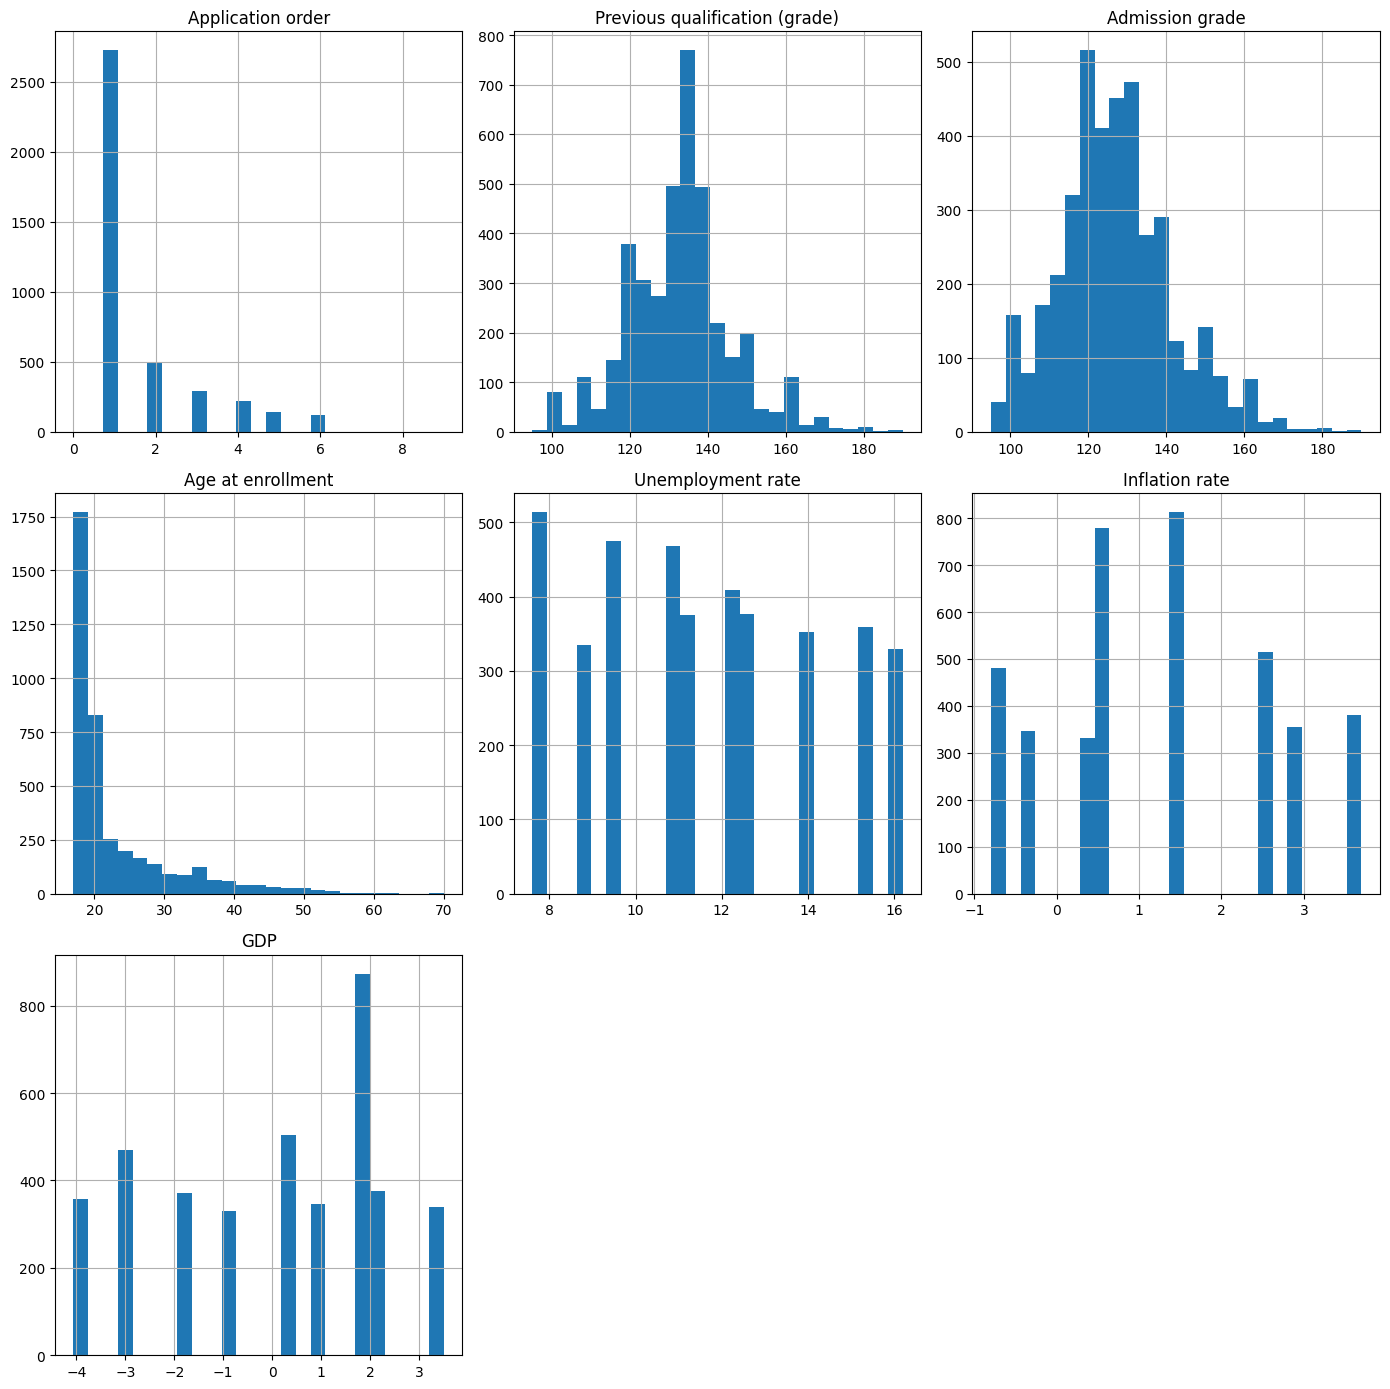

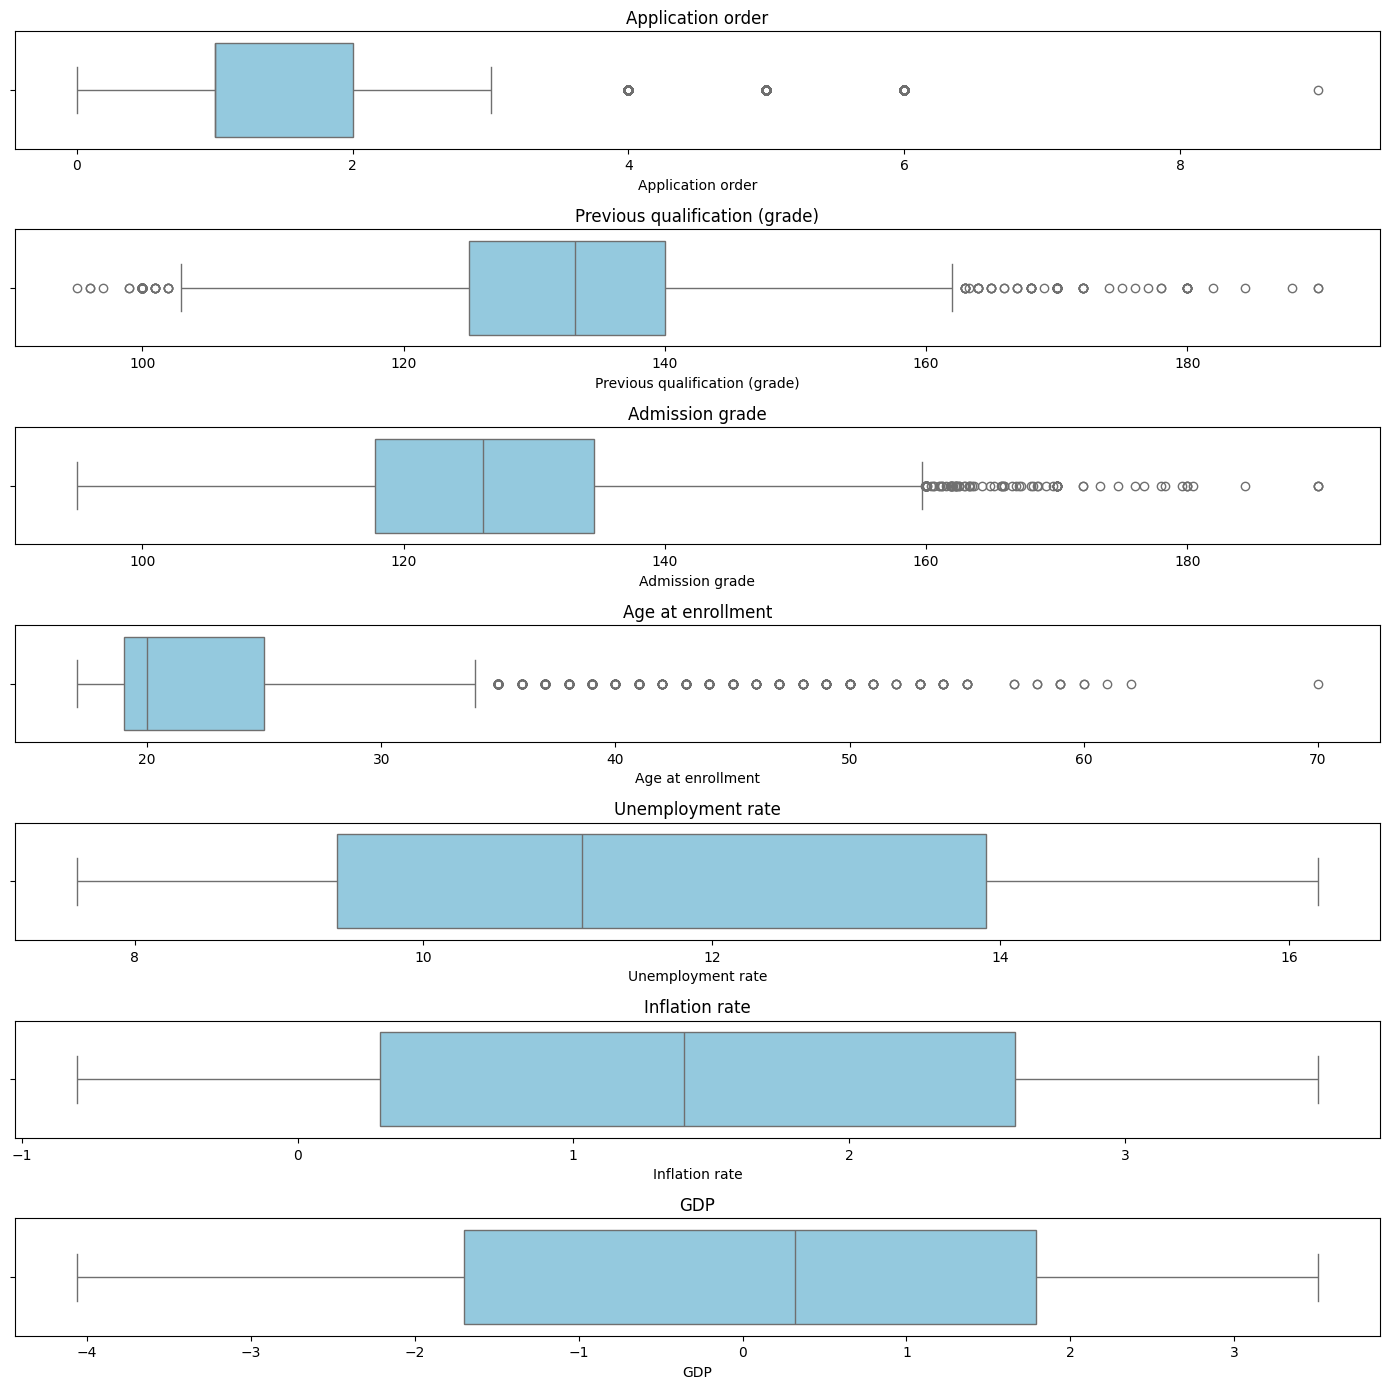

In [ ]:
df[num_feats].hist(figsize=(14,14), bins=25)
plt.tight_layout(); plt.show()

# Box‑plots
plt.figure(figsize=(14, 2*len(num_feats)))
for i, col in enumerate(num_feats, 1):
    plt.subplot(len(num_feats), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout(); plt.show()


## Enhanced Distribution & Outlier Analysis

### 1. Binary / Flag Variables  
- **Displaced, Debtor, Educational special needs, Scholarship holder, Tuition fees up to date, Gender, International**  
  - All exhibit a **0–1 split** with one dominant class (> 80 %).  
  - **Actionable insight:** The minority class (≈ 10–20 % of records) may carry strong signals (e.g., “scholarship holder” often correlates with outcome). Use class-weighted algorithms or generate synthetic samples if needed.

### 2. Low-Cardinality Codes & Ordinal Features  
- **Application mode**: three peaks around values ≈ 0, 20, 40  
- **Application order**: heavy concentration at 0–2, but outliers up to 9  
- **Course**, **Previous qualification**, **Parental qualification/occupation** codes:  
  - These cluster around a handful of numeric codes (e.g. Course IDs near 9000–10000, qualification levels at {0, 10, 20, 30, 40}).  
  - **Outliers** (e.g. rare Course IDs below 2000 or occupation codes > 100) should be binned into “Other” or aggregated categories to reduce sparsity.

### 3. Academic Grades  
- **Previous qualification (grade)** and **Admission grade**  
  - Approximate **normal distributions** centered ~135 with moderate right skew.  
  - **Outliers** below 100 or above 170/180 are real but rare—likely nonstandard grading.  
  - **Recommendation:** Clip or Winsorize extreme grades, or keep them but apply robust scaling in your pipeline.

### 4. Age at Enrollment  
- Strong peak at **18–22** years (traditional students) and a **long tail** to ~65 years (mature entrants).  
- **Boxplot** shows many mild outliers beyond ~30 years.  
- **Modeling tip:** Consider grouping age into bins (e.g., 18–22, 23–30, 31+) to capture nonlinear effects and reduce noise from extreme ages.

### 5. Macro-Economic Indicators  
- **Unemployment rate** (≈ 8–16 %), **Inflation rate** (≈ –1–3 %), **GDP** (normalized to ±3):  
  - These appear as **discrete bars**, reflecting country-level data snapped to each student.  
  - **Action:** If multiple students share identical macro values, these features may act more like group identifiers than true continuous variables—consider one-hot encoding of country or clustering by macro-economic segment.

### 6. Outlier Summary  
- Features with **extreme single-point outliers** (e.g., Course IDs near 0, occupation codes > 150) should be reviewed:  
  - Are they data entry errors, special programs, or genuine rare cases?  
  - You can drop or recode these into an “Other” category to improve model stability.

---



**Categorical Level Counts**

In [ ]:
cat_feats

['Marital status',
 'Application mode',
 'Course',
 'Daytime/evening attendance\t',
 'Previous qualification',
 'Nacionality',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation",
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International']

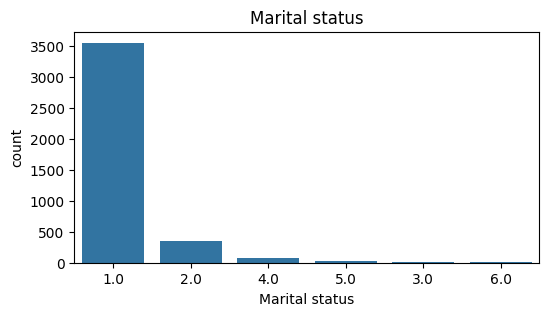

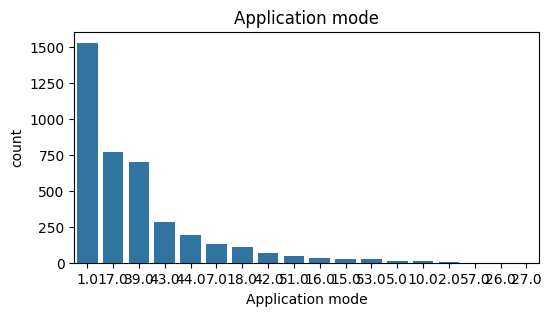

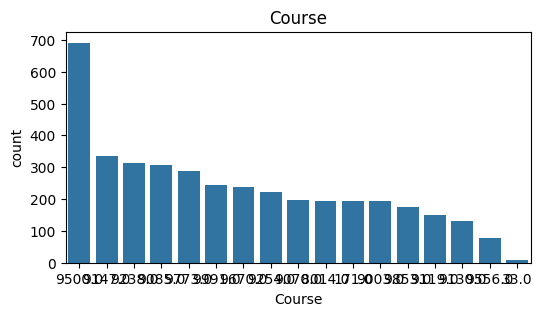

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


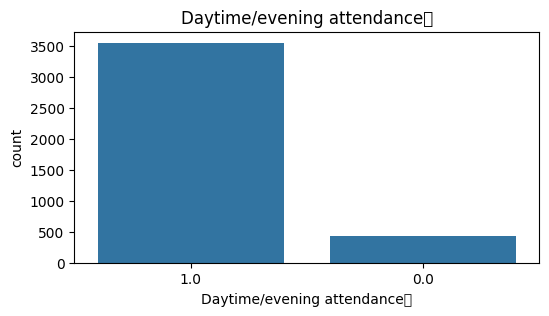

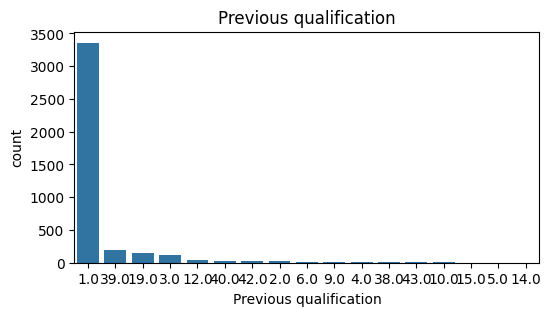

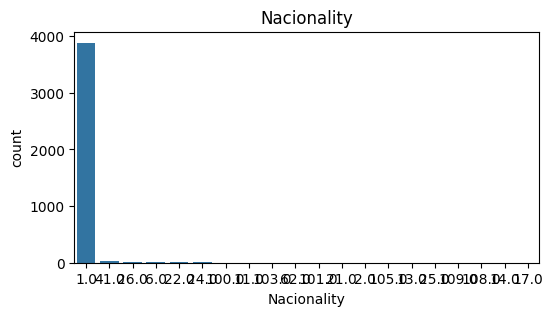

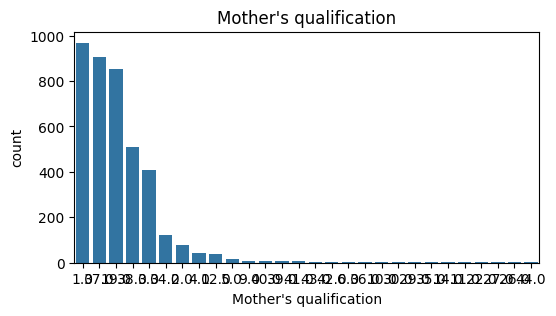

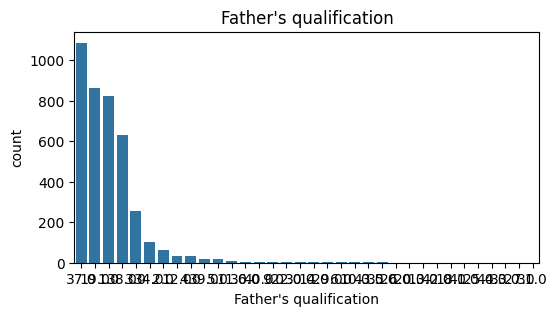

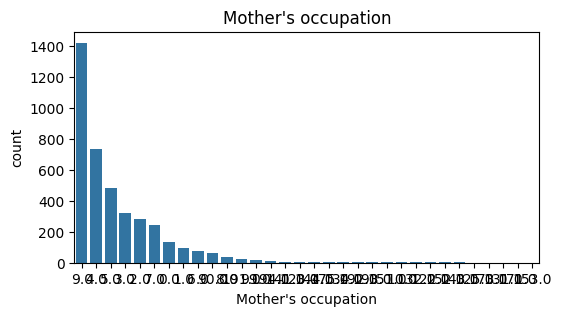

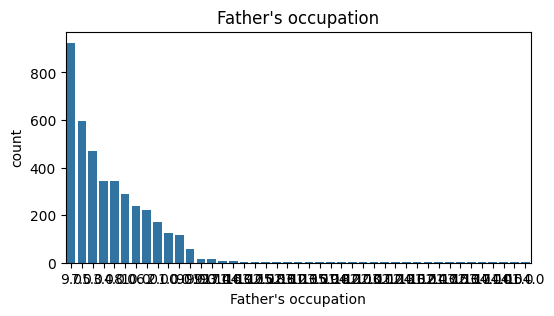

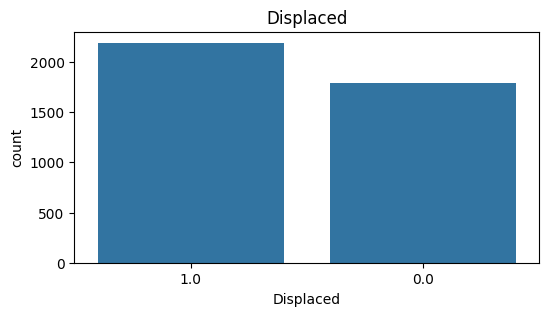

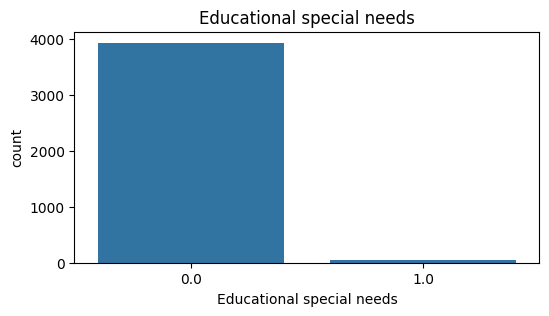

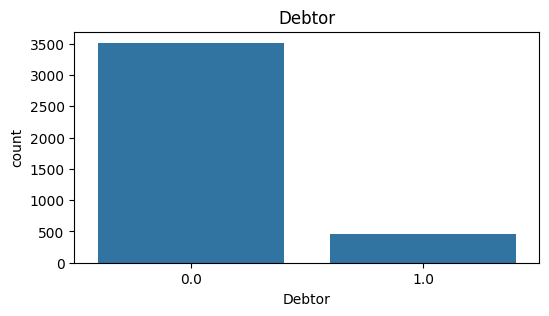

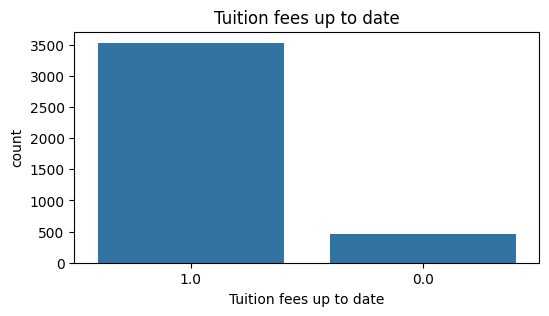

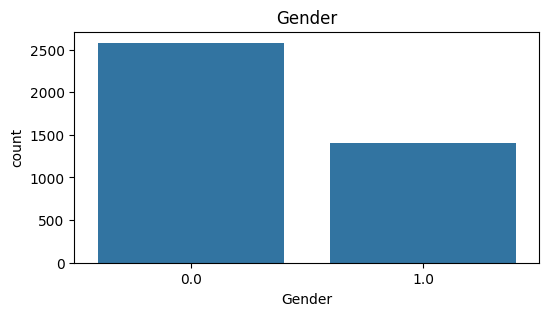

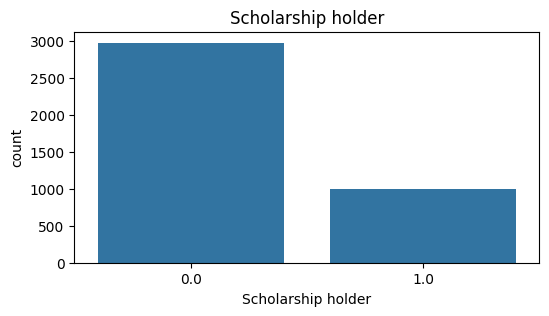

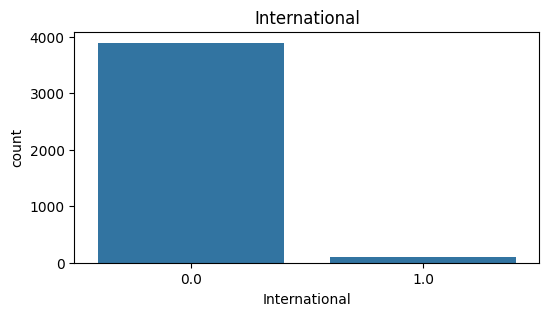

['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance\t', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'International']


In [ ]:
# ↳ code
for col in cat_feats:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    plt.xticks(rotation=0); plt.title(col); plt.show()
print(cat_feats)

# **Data‑Pre‑Processing Pipeline**
*Handles missing values → encodes categoricals → scales numerics.*

In [ ]:
drop_col = ['Target',"Father's qualification","Father's occupation","Mother's occupation"]

cat_feats = [
    "Marital status",
    "Application mode",
    "Course",
    "Daytime/evening attendance\t",
    "Previous qualification",
    "Nacionality",
    "Mother's qualification",
    # "Father's qualification",
    # "Mother's occupation",
    # "Father's occupation",
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "International"
]

num_feats = [
    "Application order",
    "Previous qualification (grade)",
    "Admission grade",
    "Age at enrollment",
    "Unemployment rate",
    "Inflation rate",
    "GDP"
]

In [ ]:
# ↳ code
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# ▶ drop rows with missing Target
df = df.dropna(subset=['Target']).reset_index(drop=True)

X = df.drop(drop_col, axis=1)
y = df['Target']

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_feats),
        ('cat', categorical_pipeline, cat_feats)
    ])

# train / test split for downstream modelling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

# final ready‑to‑fit pipeline
print(preprocessor)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Application order',
                                  'Previous qualification (grade)',
                                  'Admission grade', 'Age at enrollment',
                                  'Unemployment rate', 'Inflation rate',
                                  'GDP']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Marital status', 'Application mode',
  

# 8  Key Take‑aways
* Dataset has **24 predictor features** & **3 target classes**  
* It is a **classification** task (categorical ‘Target’).  
* Classes are **imbalanced** (Graduate > Dropout > Enrolled).  
* Highest linear correlations: e.g., ‘Admission grade’ vs ‘Previous qualification (grade)’.  
* Missing values present – handled via median / mode imputation.  
* Complete preprocessing pipeline built for reproducible research.

# **Neural network**

In [ ]:
!pip install -q xgboost scikeras[tensorflow]  # silent install (TF 2.x ships with Colab)

In [ ]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, roc_auc_score, roc_curve,
                             RocCurveDisplay)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from scikeras.wrappers import KerasClassifier   # lets us keep a sklearn‑style API


In [ ]:
# ↳ code
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

num_classes = len(le.classes_)
y_train_bin = label_binarize(y_train_enc, classes=range(num_classes))
y_test_bin  = label_binarize(y_test_enc,  classes=range(num_classes))

print("Classes:", le.classes_)


Classes: ['Dropout' 'Enrolled' 'Graduate']


Build model‑factory so scikeras can re‑create it inside cross‑validation, etc.

Combine with the **exact same** `preprocessor`

In [ ]:
# ⬅ 1.  Make sure we have compatible library versions
#!pip install -q -U scikit-learn scikeras  # (installs sklearn >=1.3, scikeras >=0.12)

import tensorflow as tf, sklearn, scikeras
print("TF :", tf.__version__, "| sklearn :", sklearn.__version__, "| scikeras :", scikeras.__version__)


TF : 2.18.0 | sklearn : 1.4.2 | scikeras : 0.13.0


In [ ]:
# ⬅ 2.  Fit the preprocessor once
preprocessor.fit(X_train)
n_inputs = preprocessor.transform(X_train.iloc[[0]]).shape[1]


In [ ]:
# ⬅ 3.  Build the Keras model factory
def make_dense_nn(n_inputs, n_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(n_inputs,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:

from scikeras.wrappers import KerasClassifier
from sklearn.pipeline    import Pipeline

nn_clf = KerasClassifier(
    model=make_dense_nn,
    model__n_inputs=n_inputs,
    model__n_classes=num_classes,
    epochs=100,
    batch_size=64,
    validation_split=0.15,                 # ← gives EarlyStopping its 'val_loss'
    verbose=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=8, restore_best_weights=True)
    ]
)

nn_pipe = Pipeline(steps=[
    ('prep', preprocessor),    # already fitted but harmless to reuse
    ('nn',   nn_clf)
])


history = nn_pipe.fit(X_train, y_train_enc)


Evaluate NN

Neural Network
              precision    recall  f1-score   support

     Dropout       0.62      0.57      0.60       382
    Enrolled       0.28      0.05      0.08       216
    Graduate       0.64      0.87      0.74       594

    accuracy                           0.62      1192
   macro avg       0.51      0.49      0.47      1192
weighted avg       0.57      0.62      0.57      1192



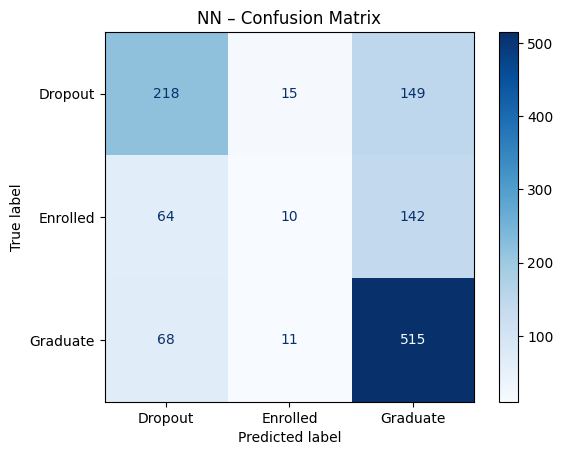

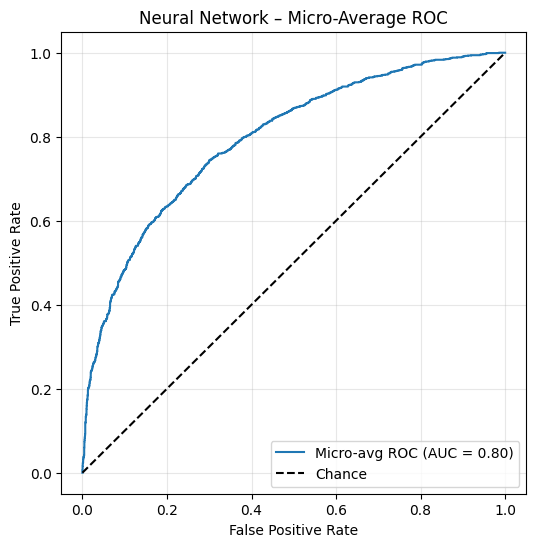

In [ ]:
# ↳ code
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
keras_model = nn_pipe.named_steps['nn'].model_
# 1️⃣  Pre-transform the test set once (already done)
X_test_trans = preprocessor.transform(X_test)

# 2️⃣  Pure Keras prediction
y_nn_pred_prob = keras_model.predict(X_test_trans, verbose=0)
y_nn_pred      = y_nn_pred_prob.argmax(axis=1)

# 3️⃣  Standard classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Neural Network")
print(classification_report(y_test_enc, y_nn_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_nn_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
plt.title('NN – Confusion Matrix')
plt.show()

# 4️⃣  Compute micro-average ROC curve and AUC
y_true_flat  = y_test_bin.ravel()         # flatten one-vs-rest true labels
y_score_flat = y_nn_pred_prob.ravel()     # flatten predicted probabilities

fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
auc_micro = roc_auc_score(
    y_test_bin, y_nn_pred_prob,
    multi_class='ovr',
    average='micro'
)

# 5️⃣  Plot the single micro-average ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr_micro, tpr_micro,
         label=f"Micro-avg ROC (AUC = {auc_micro:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("Neural Network – Micro-Average ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **4   Random Forest Pipeline**

Random Forest (CPU)
              precision    recall  f1-score   support

     Dropout       0.63      0.59      0.61       382
    Enrolled       0.38      0.12      0.18       216
    Graduate       0.65      0.85      0.74       594

    accuracy                           0.63      1192
   macro avg       0.55      0.52      0.51      1192
weighted avg       0.60      0.63      0.59      1192



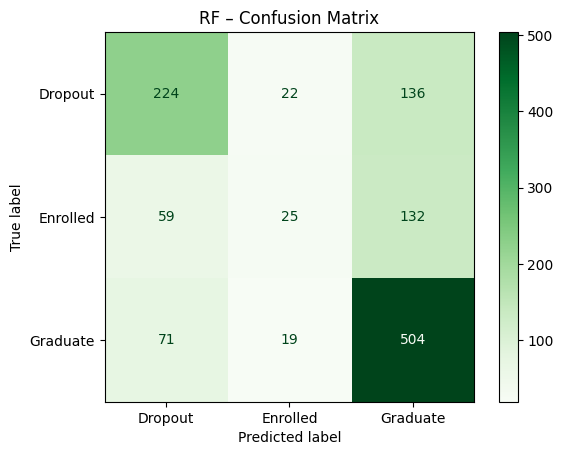

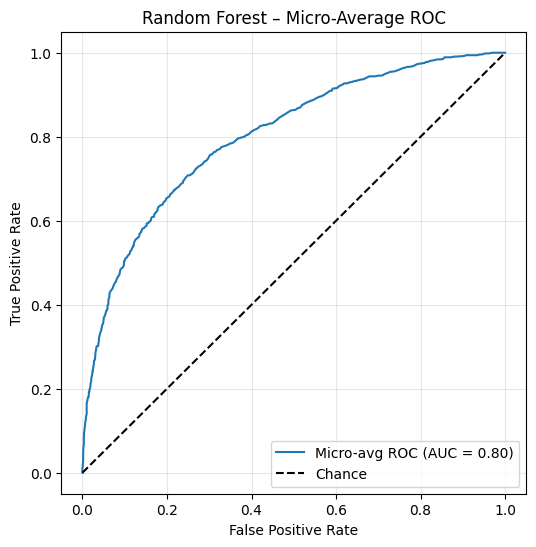

In [ ]:
# ↳ code
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt


rf_pipe = Pipeline([
    ('prep', preprocessor),   #  fitted ColumnTransformer
    ('rf', RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
rf_pipe.fit(X_train, y_train_enc)

# 2️⃣  Generate predictions
y_rf_pred      = rf_pipe.predict(X_test)
y_rf_pred_prob = rf_pipe.predict_proba(X_test)

# 3️⃣  Standard classification metrics
print("Random Forest (CPU)")
print(classification_report(y_test_enc, y_rf_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_rf_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Greens')
plt.title("RF – Confusion Matrix")
plt.show()

# 4️⃣  Compute a single, micro-average ROC curve
# Flatten true labels and probabilities for one-vs-rest micro-avg
y_true_flat  = y_test_bin.ravel()
y_score_flat = y_rf_pred_prob.ravel()

fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
auc_micro = roc_auc_score(
    y_test_bin, y_rf_pred_prob,
    multi_class='ovr', average='micro'
)

# 5️⃣  Plot the single ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr_micro, tpr_micro,
         label=f"Micro-avg ROC (AUC = {auc_micro:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest – Micro-Average ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **5   XGBoost Pipeline**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



XGBoost (GPU)
              precision    recall  f1-score   support

     Dropout       0.63      0.55      0.59       382
    Enrolled       0.38      0.22      0.28       216
    Graduate       0.67      0.82      0.74       594

    accuracy                           0.63      1192
   macro avg       0.56      0.53      0.53      1192
weighted avg       0.60      0.63      0.61      1192



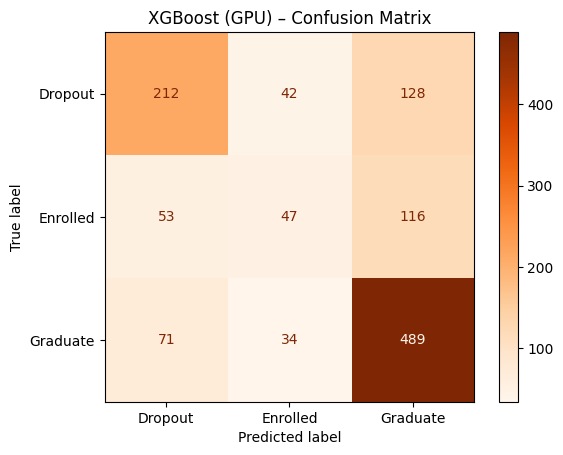

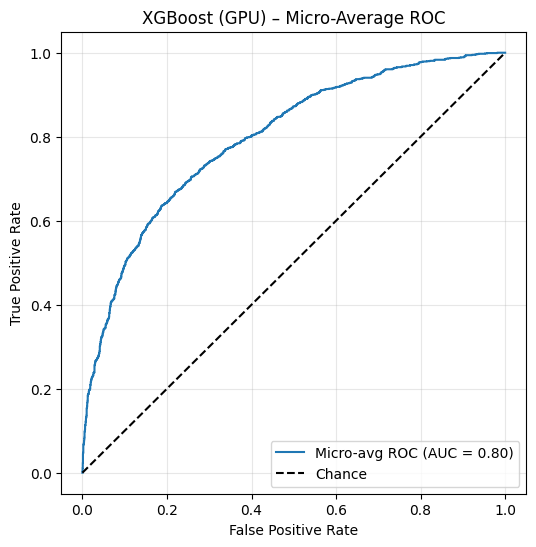

In [ ]:
# ↳ code
# 1️⃣  Imports
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)

# 2️⃣  Define the GPU‐accelerated XGBoost classifier
xgb_gpu = XGBClassifier(
    tree_method="gpu_hist",       # use GPU for training
    predictor="gpu_predictor",    # use GPU for inference
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=600,
    learning_rate=0.04,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="mlogloss",
    random_state=42
)

# 3️⃣  Build the pipeline
xgb_pipe_gpu = Pipeline([
    ('prep', preprocessor),   # your fitted ColumnTransformer
    ('xgb',  xgb_gpu)
])

# 4️⃣  Train on the CPU (preprocessing) + GPU (model)
xgb_pipe_gpu.fit(X_train, y_train_enc)

# 5️⃣  Predict on test set
y_xgb_pred      = xgb_pipe_gpu.predict(X_test)
y_xgb_pred_prob = xgb_pipe_gpu.predict_proba(X_test)

# 6️⃣  Classification report
print("\nXGBoost (GPU)")
print(classification_report(y_test_enc, y_xgb_pred, target_names=le.classes_))

# 7️⃣  Confusion matrix
cm = confusion_matrix(y_test_enc, y_xgb_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Oranges')
plt.title("XGBoost (GPU) – Confusion Matrix")
plt.show()

# 8️⃣  Single micro-average ROC curve
# Flatten for one-vs-rest micro-avg
y_true_flat  = y_test_bin.ravel()
y_score_flat = y_xgb_pred_prob.ravel()

fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
auc_micro = roc_auc_score(
    y_test_bin,
    y_xgb_pred_prob,
    multi_class="ovr",
    average="micro"
)

plt.figure(figsize=(6, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-avg ROC (AUC = {auc_micro:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("XGBoost (GPU) – Micro-Average ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **KNN**

K-Nearest Neighbors
              precision    recall  f1-score   support

     Dropout       0.55      0.48      0.51       382
    Enrolled       0.25      0.19      0.21       216
    Graduate       0.62      0.71      0.66       594

    accuracy                           0.54      1192
   macro avg       0.47      0.46      0.46      1192
weighted avg       0.53      0.54      0.53      1192



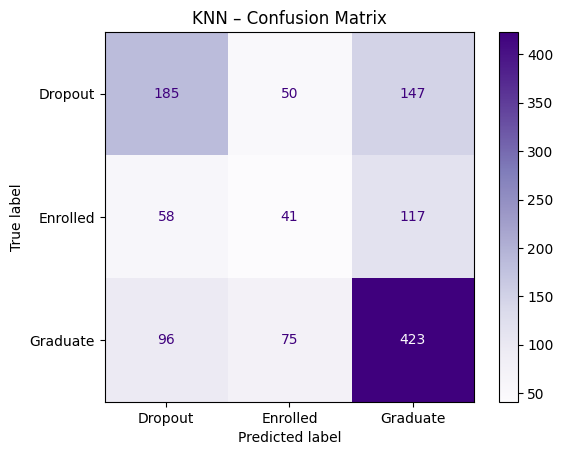

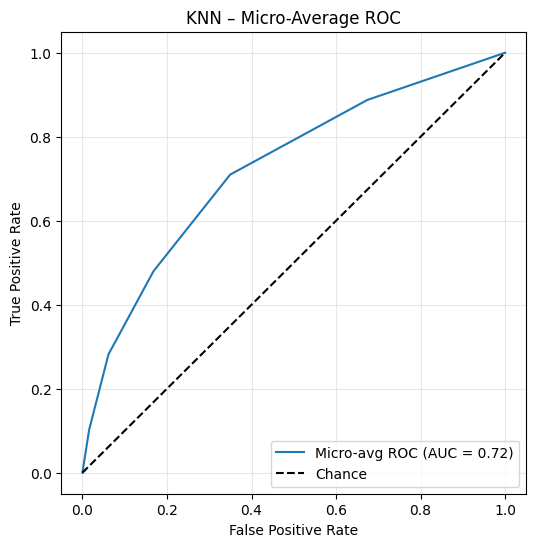

In [ ]:
# ↳ code
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# 1️⃣  Build & train KNN pipeline
knn_pipe = Pipeline([
    ('prep', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='uniform', n_jobs=-1))
])
knn_pipe.fit(X_train, y_train_enc)

# 2️⃣  Predict & evaluate
y_knn_pred      = knn_pipe.predict(X_test)
y_knn_pred_prob = knn_pipe.predict_proba(X_test)

print("K-Nearest Neighbors")
print(classification_report(y_test_enc, y_knn_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_knn_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Purples')
plt.title("KNN – Confusion Matrix")
plt.show()

# 3️⃣  Micro-average ROC
y_true_flat  = y_test_bin.ravel()
y_score_flat = y_knn_pred_prob.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
auc_micro = roc_auc_score(y_test_bin, y_knn_pred_prob, multi_class='ovr', average='micro')

plt.figure(figsize=(6,6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-avg ROC (AUC = {auc_micro:.2f})")
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("KNN – Micro-Average ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **Decision Tree**

Decision Tree
              precision    recall  f1-score   support

     Dropout       0.51      0.47      0.49       382
    Enrolled       0.24      0.25      0.25       216
    Graduate       0.63      0.66      0.64       594

    accuracy                           0.52      1192
   macro avg       0.46      0.46      0.46      1192
weighted avg       0.52      0.52      0.52      1192



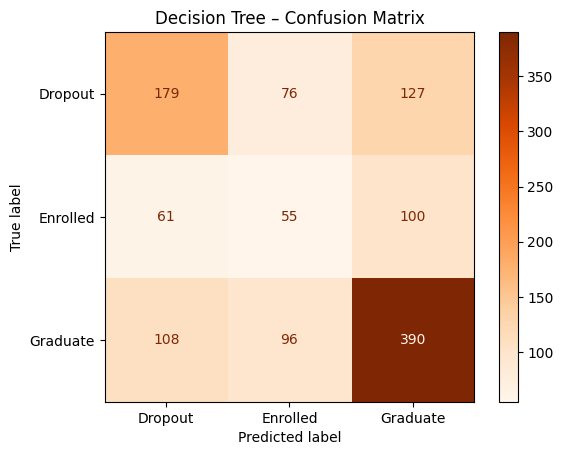

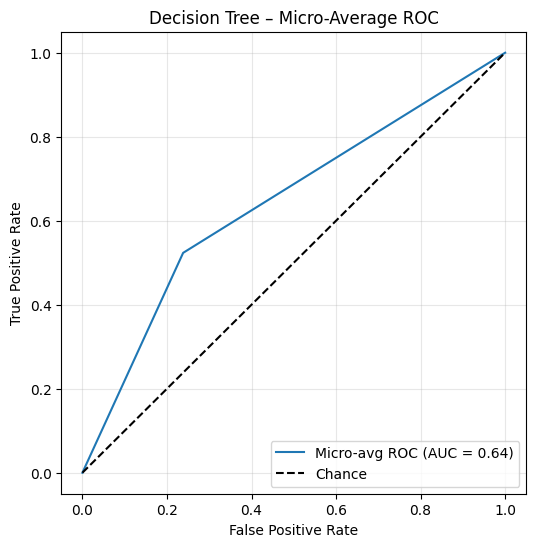

In [ ]:
# ↳ code
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# 1️⃣  Build & train Decision Tree pipeline
dt_pipe = Pipeline([
    ('prep', preprocessor),
    ('dt', DecisionTreeClassifier(
        criterion='gini',
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight='balanced',
        random_state=42
    ))
])
dt_pipe.fit(X_train, y_train_enc)

# 2️⃣  Predict & evaluate
y_dt_pred      = dt_pipe.predict(X_test)
y_dt_pred_prob = dt_pipe.predict_proba(X_test)

print("Decision Tree")
print(classification_report(y_test_enc, y_dt_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_dt_pred)
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Oranges')
plt.title("Decision Tree – Confusion Matrix")
plt.show()

# 3️⃣  Micro-average ROC
y_true_flat  = y_test_bin.ravel()
y_score_flat = y_dt_pred_prob.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_true_flat, y_score_flat)
auc_micro = roc_auc_score(y_test_bin, y_dt_pred_prob, multi_class='ovr', average='micro')

plt.figure(figsize=(6,6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-avg ROC (AUC = {auc_micro:.2f})")
plt.plot([0,1],[0,1],'k--', label='Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree – Micro-Average ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# **Logistic Regression**

Logistic Regression
              precision    recall  f1-score   support

     Dropout       0.62      0.54      0.58       382
    Enrolled       0.31      0.42      0.35       216
    Graduate       0.72      0.69      0.70       594

    accuracy                           0.59      1192
   macro avg       0.55      0.55      0.55      1192
weighted avg       0.61      0.59      0.60      1192



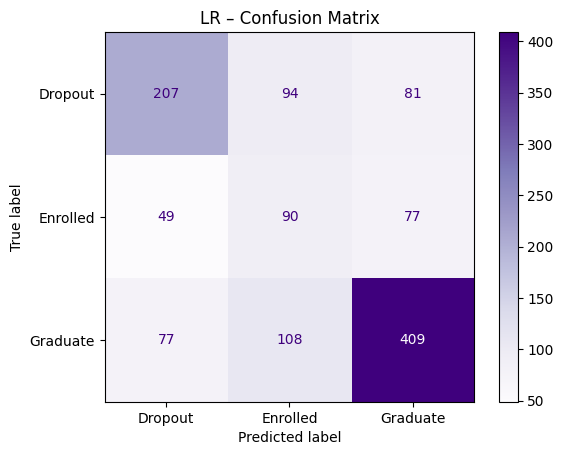

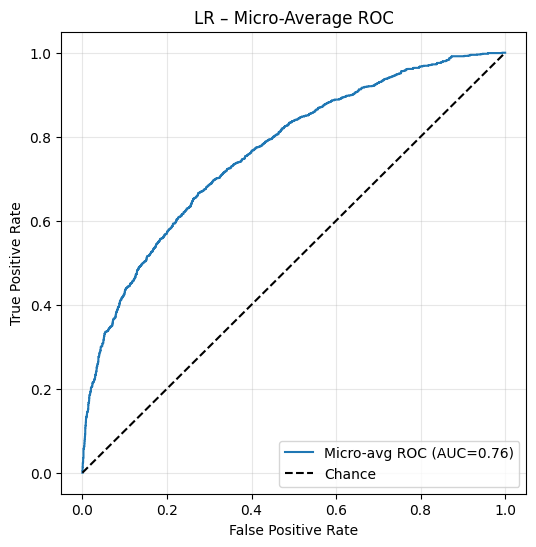

In [ ]:
# ↳ code
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

# 1) Drop the target and the two parental‐qualification cols from df
df2 = df.drop(drop_col, axis=1)
y   = df['Target']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df2, y, test_size=0.3, stratify=y, random_state=42
)

# 3) Define your feature lists (minus the dropped ones!)

# 4) Build a preprocessor that outputs a **dense** array
numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])
categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,   num_feats),
    ('cat', categorical_pipeline, cat_feats)
])

# 5) Fit & transform
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

# 6) Encode the target
le = LabelEncoder().fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc  = le.transform(y_test)

# 7) Binarize for ROC-AUC
y_train_bin = label_binarize(y_train_enc, classes=range(len(le.classes_)))
y_test_bin  = label_binarize(y_test_enc,  classes=range(len(le.classes_)))

# 8) Train logistic regression
lr = LogisticRegression(
    max_iter=1000, class_weight='balanced',
    solver='lbfgs', multi_class='ovr', n_jobs=-1
)
lr.fit(X_train_pre, y_train_enc)

# 9) Predict & evaluate
y_lr_pred      = lr.predict(X_test_pre)
y_lr_prob      = lr.predict_proba(X_test_pre)

print("Logistic Regression")
print(classification_report(y_test_enc, y_lr_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_lr_pred, display_labels=le.classes_, cmap='Purples'
)
plt.title("LR – Confusion Matrix")
plt.show()

# 10) Single micro-avg ROC
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_lr_prob.ravel())
auc_micro   = roc_auc_score(y_test_bin, y_lr_prob, multi_class='ovr', average='micro')

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Micro-avg ROC (AUC={auc_micro:.2f})")
plt.plot([0,1],[0,1],'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LR – Micro-Average ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


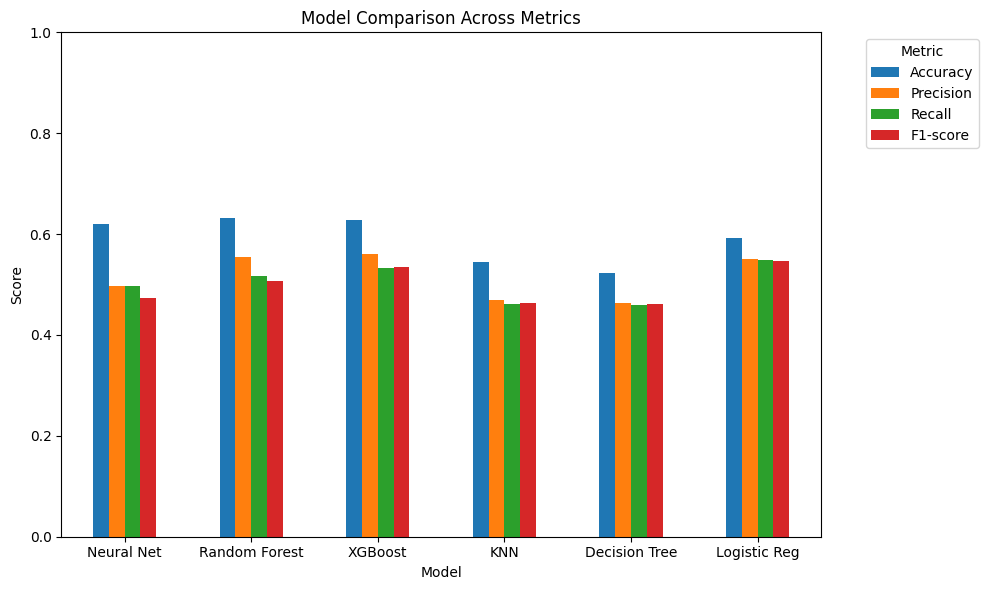

In [ ]:
# ↳ code
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Collect predictions into a dict
model_preds = {
    "Neural Net":     y_nn_pred,
    "Random Forest":  y_rf_pred,
    "XGBoost":        y_xgb_pred,
    "KNN":            y_knn_pred,
    "Decision Tree":  y_dt_pred,
    "Logistic Reg":   y_lr_pred,

}

# 2) Compute metrics for each
rows = []
for name, preds in model_preds.items():
    rows.append({
        "Model":     name,
        "Accuracy":  accuracy_score(y_test_enc, preds),
        "Precision": precision_score(y_test_enc, preds, average="macro", zero_division=0),
        "Recall":    recall_score(y_test_enc, preds, average="macro", zero_division=0),
        "F1-score":  f1_score(y_test_enc, preds, average="macro", zero_division=0)
    })

metrics_df = pd.DataFrame(rows).set_index("Model")

# 3) Plot grouped bar chart
ax = metrics_df.plot(
    kind="bar",
    figsize=(10, 6),
    ylabel="Score",
    ylim=(0, 1.0),
    rot=0
)
plt.title("Model Comparison Across Metrics")
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


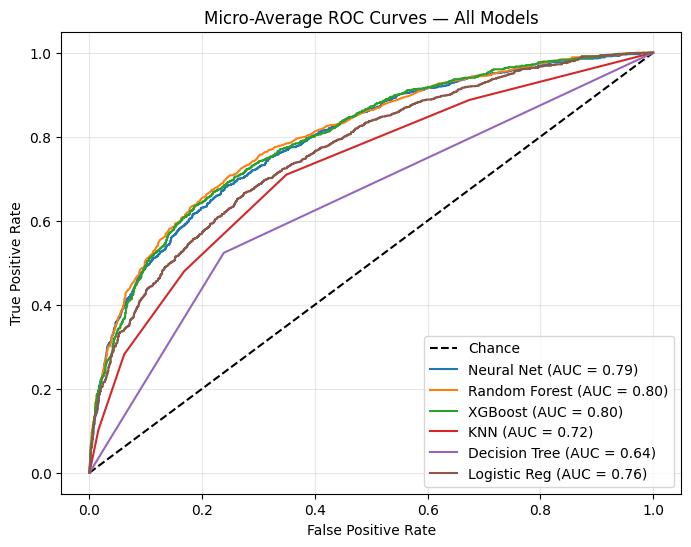

In [ ]:
# ↳ code
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1) Ensure you have these one-hot truth & probability arrays in memory:
#    y_test_bin, y_nn_pred_prob, y_rf_pred_prob,
#    y_xgb_pred_prob, y_knn_pred_prob, y_dt_pred_prob, y_lr_prob

model_probs = {
    "Neural Net":     y_nn_pred_prob,
    "Random Forest":  y_rf_pred_prob,
    "XGBoost":        y_xgb_pred_prob,
    "KNN":            y_knn_pred_prob,
    "Decision Tree":  y_dt_pred_prob,
    "Logistic Reg":   y_lr_prob,
}

# 2) Plot all micro-average ROC curves together
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

for name, prob in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), prob.ravel())
    auc = roc_auc_score(y_test_bin, prob, multi_class='ovr', average='micro')
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.title("Micro-Average ROC Curves — All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
